## The Quantum Approximate Optimization Algorithm

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
import cirq
import numpy as np
import math
import random
from scipy.optimize import minimize

*In this Notebook, we are going to be discussing the Quantum Approximate Optimization Algorithm, which is a variational quantum algorithm with the intended use of solving combinatorial problems. The first part of this Notebook will cover all of the necessary theory to understand QAOA, and the second part will discuss the applications of the algorithm (the second part of the Notebook is adapted from a blog post I wrote a couple months back).*

**Table of Contents**

**Part 1: Theory**

1. <a href="#1">Introduction</a>
2. <a href="#2">The Quantum Approximate Optimization Algorithm</a>

**Part 2: Application**

3. <a href="#3">Some Code for Graph Theory</a>
4. <a href="#4">Solving MaxCut with QAOA</a>
5. <a href="#5">Solving MaxClique with QAOA</a>
6. <a href="#6">Solving the Travelling Salesman Problem With QAOA</a>
7. <a href="#7">Conclusion and Further Use-Cases</a>
<br><br>
8. <a href="#8">Acknowledgements and Further Reading</a>

<div class="#1"></div>

**Introduction**

Combinatorial problems arise in essential every field of scientific inquiry. The purpose of this Notebook is to outline which computational problems can be classified under the umbrella of combinatorial problems, describe how QAOA can be used to solve these problems, and then introduce some specific examples of problems, and demonstrate (through simulations) exactly how these problems can be solved with QAOA.

**The Quantum Approximate Optimization Algorithm**

*It is important to note that for the purpose of this tutorial, we will assume that the reader is familiar with variational quantum algorithms and the Variational Quantum Eigensolver. If not, a tutorial on these topics can be found in the <a href="https://lucaman99.github.io/nomadiq/openqml/gallery.html">OpenQML gallery</a>.*

In 2014, Farhi, Goldstone, and Gutmann proposed a variational algorithm called the [Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028). technically speaking, this algorithm allows us to find the ground eigenstate of a Hamiltonian that is **diagonal in the computational basis**. By doing this, we are able to solve combinatorial problems (by finding a bitstring that optimizes some cost function). Consider some Hamiltonian, $\hat{H}$, that is diagonal in the space spanned by our $Z$-basis vectors. These computational basis vectors are usually thought of as all length $n$ bitstrings, for a collection of $n$ different qubits. For instance, for $n \ = \ 2$, we have our set of computational basis vectors as $\{|00\rangle, \ |01\rangle, \ |10\rangle, \ |11\rangle\}$. For our Hamiltonian operator to be diagonal means that it can be written as a matrix, with respect to the computational basis in the form:
<br><br>
$$\hat{H} \ = \ \text{diag}(h_1, \ h_2, \ ..., \ h_n)$$
<br>
Which means that the only non-zero elements of $\hat{H}$ lie on the diagonal. The reason we are interested in Hamiltonians of this form is because we wish to find the bitstring that optimizes a cost function. As you may remember from the VQE Notebook, the goal of a variational algorithm is to find the minimum eigenvalue and correponding minimal eigenvector of a given Hamiltonian. The class of optimization problems that can be represented as diagonal Hamiltonians **only allow basis states, not linear combinations of basis states as solutions**. It is easy to see that the eigenvectors of this kind of matrix will be the basis states themselves, thus the minimum energy (the minimum eigenvalue) of the Hamiltonian will correspond to one of the basis states. 

This algorithm is a variational quantum algorithm, meaning that it is built with **parametrized quantum gates**. Basically, we have a quantum circuit that prepares some state (we call this state-preparation circuit the **ansatz**), where each quantum gate "transforms" the qubit state according to some complex number that is fed into the circuit initially. We let the quantum circuit be represented as some parametrized unitary transformation $U(\boldsymbol\theta)$. This acts upon our initial state:
<br><br>
$$U(\boldsymbol \theta) |\psi_0\rangle \ = \ |\psi(\boldsymbol\theta)\rangle$$
<br>
The expectation value of the Hamiltonian with respect to the prepared state is then calculated (given by $\langle \psi(\boldsymbol\theta) | \hat{H} | \psi(\boldsymbol\theta) \rangle $). Now, we take this value and feed it into a classical optimizer. We repeatedly cycle through this process, letting the classical optimizer choose $\boldsymbol\theta$ until we find the lowest expected cost. We then repeatedly query the circuit a certain number of times with the optimal parameters and choose the sampled value with the lowest cost (you can read more about why this works in the VQE notebook).

The QAOA is in a certain sense very unique because of the specific way that $U(\boldsymbol\theta)$ is constructed. Specifically, the algorithm borrows ideas from [Adiabatic Quantum Computation](https://en.wikipedia.org/wiki/Adiabatic_quantum_computation) and makes $U$ an approximation/parametrized form of the time-evolution operator:
<br><br>
$$\hat{U}_T \ = \ e^{- i \hat{H} t / \hbar}$$
<br>
for a quantum system that is being adiabatically "transitioned" from one Hamiltonian to another:
<br><br>
$$\hat{H}(t) \ = \ \Big(1 \ - \ \dfrac{t}{T}\Big) \hat{H}_{0} \ + \ \dfrac{t}{T} \hat{H}_1$$
<br>
In Adiabatic QC, the idea is that if one starts off some quantum computational process in the ground state of $\hat{H}_{0}$, which is some "simple Hamiltonian", then if the system is perturbed adiabatically (as $T \ \rightarrow \ \infty$), the Adiabatic Quantum Theorem says that the state of the system approaches the ground state of $\hat{H}_1$, thus effectively finding the ground state of an "interesting" Hamiltonian. QAOA is slightly different in the sense that it Trotterizes and parametrizes this time-evolution unitary. For a time-dependent Hamiltonian, the time-evolution operator is given as:
<br><br>
$$\hat{U}_T \ = \ \exp \Big[ - \dfrac{i}{\hbar} \displaystyle\int_{0}^{T} \hat{H}(t) \ dt \Big] \ \approx \ \exp \Big[ - \dfrac{i}{\hbar} \displaystyle\sum_{t \ = \ 0}^{\left \lceil{T / \Delta t} \right \rceil} \hat{H}(t \Delta t) \ \Delta t \Big]$$
<br>
For the QAOA ansatz, we take the "summation-form" of $\hat{U}_T$ (on the right-hand side of the equation), and we truncate it at some finite depth (rather than letting the number of terms continue off to infinity). Now, by [the Baker-Campbell-Hausdorff formula](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula), expanding this exponential in terms of qubit gates is going to be essentially impossible (as, in general, $\hat{H}_0$ and $\hat{H}_1$ don't commute). Instead of doing, this we approximate this expansion, by simply decomposing the sum in the exponential as a product of exponentials, and parametrizing the "layers" of the unitary, giving us the QAOA ansatz:
<br><br>
$$U(\boldsymbol\theta) \ = \ \displaystyle\prod_{i \ = \ 1}^{P} \ e^{-i \alpha_i \hat{H}_0} e^{-i \gamma_i \hat{H}_1} \ \ \ \ \boldsymbol\theta \ = \ \{\boldsymbol\gamma, \ \boldsymbol\alpha\} $$
<br>
Thus, instead of slowly "switching" from one Hamiltonian to another, we use a parametrized circuit to "jump" around the search space, with the exponential $\hat{H}_0$ acting as a "mixer" that explores the search space of possible solution, and the exponential $\hat{H}_1$ acting as a "cost unitary" that evolves our state in the direction of the optimal solution. In the case of QAOA for combinatorial optimization, $\hat{H}_1$, the Hamiltonian whose ground state we are trying to evolve towards, we set equal to the diagonal Hamiltonian that encodes our combinatorial problem. For $\hat{H}_{0}$, we choose a **non-commuting**, usually simple (we will talk about the mathematical motivation for this in the section below) Hamiltonian. In addition, we often choose our initial qubit state $|\psi_0\rangle$ to be an even superposition over all computational basis states, which allows for a large initial search space (note that this isn't **always** the case, sometime we can be a bit smarter, as you will see when we attempt to solve the Travelling Salesman Problem).

**Some Code For Graph Theory**

We are going to start the applications section of this Notebook off by introducing a few pieces of code that will make it much easier to encode combinatorial problems into QAOA. Many combinatorial problems can be very naturally visualized as graphs, thus, it makes sense for us to write a bit of code that allows us to construct graphs for oursevles:

In [1]:
class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)

class Edge:
    def __init__(self, start_node, end_node):
        self.start_node = start_node
        self.end_node = end_node

Basically, we have just defined the `Graph` object, which can be constructed using a series of `Edge` objects. As you will see very soon, this little bit of code will be very helpful.

**A Basic Example: Solving MaxCut with QAOA**

<p>
                    The first use case of QAOA that we are going to look into is the MaxCut problem. This problem is as follows: given some undirected graph $G \ = \ (V, \ E)$, find the <b>cut</b>
                    that passes through $S \ \subset \ E$, such that $|S|$ is maximized. A cut is defined as a partition of the nodes of a graph into two subsets, $A$ and $B$, such that
                    $A \ \cup \ B \ = \ V$ and $A \ \cap \ B \ = \ \emptyset$. To determine $|S|$, we can look at each $a \ \in \ A$. If there exists some $b \ \in \ B$ such that $(a, \ b) \ \in \ E$, then
                    we add $1$ to $|S|$, continuing this process until we have checked all $a$.
                    <br><br>
                    An equivalent way to formulate this problem is through the language of graph colouring. Consider, instead of thinking about partitioning in terms of a cut, we create partitions based on
                    whether we colour specific nodes of our graph black or white. Thus, we have two sets of nodes, $W$ for white and $B$ for black, such that $W \ \cup \ B \ = \ V$ and $W \ \cap \ B \ = \ 
                    \emptyset$. We wish to maximize the number of edges that end in nodes that have different colourings. We can construct this by considering each $w \ \in \ W$. If there exists some $b \ \in \ B$,
                    such that $(w, \ b) \ \in \ E$, then we know that we have an edge with different-coloured endings, and we add $1$ to our "score". Looking back, this is completely equivalent to the "cutting" formulation
                    of this problem.
                  </p>
                <p>
                    As it turns out, the problem of figuring out this partition of nodes is a computationally difficult problem (NP-complete). Despite this, the near-term quantum algorithm, QAOA, is pretty
                    good at solving these types of problems. QAOA actually doesn't show any speedup for small graphs like the ones we will investigate in this post, but nevertheless, it is a fun idea to think
                    about.
                    <br><br>
                    We will turn our attention to the
                    cost Hamiltonian first. Recall that we are interested in finding the colouring of our graph that yields the maximum number of edges with endings of different colours. Thus, it would
                    make sense for our cost function to "reward" edges with different-coloured endings, and do nothing when the endings are the same colour. In fact, we can quantify this. Let's say that $-1$ is
                    added to our overall cost function when adjacent nodes have different colours, and $0$ when they are the same (as we are trying to <b>minimize</b> our cost function). 
                    <br><br>
                    We also know that within
                    a quantum computer, our qubits, when measured, take on one of the <b>computational basis states</b> corresponding to the basis in which we are performing measurement. For each individual
                    qubit, that "basis value" can be denoted by $0$ or $1$. Thus, for each individual qubit $|0\rangle$ corresponds to a black colouring, and $|1\rangle$ corresponds to a white colouring. 
                    However, in , we are not going to 
                    use $0$ and $1$, instead using $1$ and $-1$, respectively, in their place (the reasoning for this will
                    become apparent very soon). Thus, we assign $1$ to a <b>black colouring</b> of a node and $-1$ to a <b>white colouring</b> of a node. We then define our cost function
                    as follows:
                    <br><br>
                    $$C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} (c_a c_b \ - \ 1) \ \ \ \ \ (a, \ b) \ \in \ E$$
                    <br>
                    Where $c_a$ and $c_b$ represent colourings of vertex $a$ and vertex $b$ respectively. As you can check for yourself, when $c_a \ \neq \ c_b$, we get a value of $-1$, and when $c_a \ = \ c_b$, 
                    we get $0$. Our cost function then sums over all $a$ and $b$ that are joined by an edge.
                    <br><br>
                    Now that we have a "classical" cost function, we can map it to the language of quantum computing. This essentially means that we need to map the $c_n$ "function" that tells us the colouring of
                    a specific node to some operator. This is sort of like an analogue of a function: an operator takes its eigenvectors as "argument" and assigns each of them an eigenvalue. We can then calculate the
                    expectation value of that operator with respect to our state to get a "weighted average" of all the different values of the function that <b>could have</b> been measured, with respect to our state.
                    <br><br>
                    Luckily, the $Z$ operator is exactly the tool we need to accomplish this. In case you forgot, $Z \ = \ \text{diag}(1, \ -1)$, so it is easy to see that the eigenvalues are $1$ and $-1$, with
                    eigenvectors $|0\rangle$ and $|1\rangle$ respectively. Thus, in order to create a cost Hamiltonian that acts upon states representing vertices coloured black and white, all we have to do is sub out,
                    the $c_a$ and $c_b$ variables for $Z_a$ and $Z_b$. Thus, we get:
                    <br><br>
                    $$\hat{H}_C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} (Z_a \ \otimes \ Z_b \ - \ \mathbb{I}) \ \ \ \ \ (a, \ b) \ \in \ E$$
                    <br>
                    We can easily verify that this operator acting on pairs of basis states, $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$ yields the expected values of $-1$ and $0$.
                    <br><br>
                    In order to choose our mixer Hamiltonian, the general strategy is to find something that does not commute with $\hat{H}_C$, so that the algorithm is able to explore all possibilities in the
                    search space. Consider what would happen in $\hat{H}_{M}$ <b>did commute</b> with $\hat{H}_C$, and each value of our spectrum is unique to a specific eigenvector (which they are). 
                    This would imply, $|\psi\rangle$ is an eigenstate of $\hat{H}_C$ if and only if it is an eigenstate
                    of $\hat{H}_M$. Let $|\psi\rangle$ be an eigenstate of $\hat{H}_C$:
                    <br><br>
                    $$\hat{H}_M \hat{H}_C \ - \ \hat{H}_C \hat{H}_M \ = \ 0 \ \Rightarrow \ \hat{H}_M \hat{H}_C |\psi\rangle \ - \ \hat{H}_C \hat{H}_M |\psi\rangle \ = \ 0 \ \Rightarrow \ \hat{H}_C [ \hat{H}_M |\psi\rangle ]
                     \ = \ C [ \hat{H}_M |\psi\rangle ]$$
                    <br>
                    So $\hat{H}_M |\psi\rangle$ is also an eigenvector of $\hat{H}_C$. Let the set $V$ correspond to all eigenvectors of $\hat{H}_C$. It follows that
                    $\hat{H}_M |\psi\rangle \ \in \ aV$, where $a$ is some scaling value. This is to say that $\hat{H}_M$ maps our current eigenvector $|\psi\rangle$ to some new eigenvector, $|\psi'\rangle$,
                    or $\hat{H}_M$ simply scales $|\psi\rangle$ by some factor $a$. However, since we know that each value of the spectrum is unique to a single eigenvector, we c an rule out $\hat{H}_M |\psi\rangle
                     \ = \ |\psi'\rangle$, as if this were true then we would have:
                     <br><br>
                     $$\hat{H}_C \hat{H}_M |\psi\rangle \ = \ \hat{H}_M \hat{H}_C |\psi\rangle \ \Rightarrow \ \hat{H}_{C} |\psi'\rangle \ = \ C |\psi'\rangle$$
                     <br>
                     This is a contradiction, as $C$ is already the eigenvalue assigned to $|\psi\rangle$. Thus, it follows that $\hat{H}_M |\psi\rangle \ = \ a |\psi\rangle$, making $|\psi\rangle$ an
                     eigenvector of $\hat{H}_M$. We can prove the converse in an essentially identical way.
                    <br><br>
                    Since the two Hamiltonians share the same set of eigenvectors, this means that there is no "exploration" when a state vector is passed into the circuit. Consider what happens when we pass
                    some general $|\psi\rangle$ into our circuit. This can be decomposed into a linear combination of eigenvectors of the two Hamiltonians. Thus, each term in the linear combination <b>simply has phases
                    multiplied by each term</b>. This is due to the fact that our unitaries are of the form $e^{-i \omega \hat{H}}$, which becomes $e^{-i \omega E}$ when multiplied by one of the eigenstates of $\hat{H}$.
                    Since <b>only</b> adding these phases does not affect the overall probabilities of measurements for any given state, our algorithm is useless (we might as well just randomly guess solutions).
                    <br><br>
                    That was a slight diversion, let's get back on track now. We choose our mixer:
                    <br><br>
                    $$\hat{H}_M \ = \ \displaystyle\sum_{n} X_{n}$$
                    <br>
                    Where $n$ sums over all qubits. Evidently, this does not commute with $\hat{H}_C$.
                    <br><br>
                    So now that we have defined all of the necessary structure to build our algorithm, let's simulate it using Cirq! First, let's choose the graph on which we are going to perform MaxCut. For
                    the sake of simplicity, we choose a linear graph of $5$ nodes that looks something like this:
                    </p>
                    <br><br>
                    <center>
                        <img src="assets/graph.png" style="width:400px;">
                    </center>
                    <br><br>
                    <p>
                    We can start by specifying
                    all of the initial parameters that we need and defining a function that gives us our initial state, which will just be an even superposition of all basis states (high variance in the initial
                    state is good for "exploration", plus, we can motivate that from an adiabatic perspective, as this state is the ground state of $\hat{H}_M$). We'll start with QAOA over $5$ qubits, with a depth
                    of $4$. We also have to define our graph, in terms of Edge objects:</p>
                    

In [47]:
# Defines the list of qubits

num = 5
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)
    
# Defines the graph

set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 4)]

<p>We can then go on to define our cost and mixer layers, exactly as we explained them in the previous section:</p>

In [48]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZPowGate(exponent=-1*gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])

# Defines the mixer unitary

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

<p>After this, we can create a function that executes our circuit over multiple trials, and outputs lists of the bitstrings that were measured:</p>

In [49]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

Notice how we begin by defining our $\gamma$ and $\alpha$ parameters from the list of parameters passed into the function. We then initialize the qubits, apply the QAOA unitary the to the specified depth, then we measure the qubits, run the code, and prepare the outputted bits from the output data.

<p>Now, we are able to create our cost function, in order to post-process the data measured from the quantum circuit executions. Since the values that are outputted from the circuit are $0$s and
                    $1$s, instead of the desired $1$ and $-1$ values. Thus, in the place of $c_n$, we defined a function $f(x) \ = \ 1 \ - \ 2x$, which maps $0$ to $1$ and $1$ to $-1$:</p>

In [50]:
# Defines the cost function

iterations = 0

def cost_function(params):
    
    global iterations

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += 0.5*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep
    
    if (iterations % 10 == 0):
        print("Cost at Step "+str(iterations)+": "+str(total_cost))
    
    iterations = iterations + 1

    return total_cost

<p>This function outputs the expected value of the cost function (calculates the average cost over $1000$ repetitions of the algorithm). Finally, we can define a classical optimizer to tune the
                    $\gamma$ and $\alpha$ paramters until we arrive at a minimum expected value of the cost function. Along with the cost function, we write a bit of code that allows us to graph the results:</p>

Cost at Step 0: -1.878
Cost at Step 10: -2.679
Cost at Step 20: -3.465
Cost at Step 30: -3.637
Cost at Step 40: -3.619
Cost at Step 50: -3.649
Cost at Step 60: -3.62
Cost at Step 70: -3.63
Cost at Step 80: -3.646
Cost at Step 90: -3.639
     fun: -3.631
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 95
  status: 1
 success: True
       x: array([-0.75210142, -2.53704033,  0.90402927,  2.63046214,  1.3588834 ,
       -0.68411438,  1.39626614,  3.02855468])


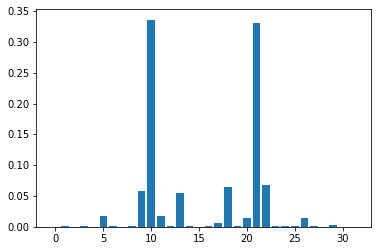

In [51]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]
x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)
plt.bar(x, y)
plt.show()


<p>
So as one can see, the states with highest probability of measurement are $|10\rangle \ = \ |01010\rangle$ and $|21\rangle \ = \ |10101\rangle$. These are the two optimal solutions to MaxCut:
                        the vertices are coloured in an alternating fashion, therefore making it such that every edge ends in nodes of different colours (the existence of
                        this "perfect" solution <b>definitely not always possible</b>, for more complex graph).
                        <br><br>
                        If we want, we can also turn up the number of nodes in our graph, and get some even cooler looking probability-plots:
                    </p>
                    <br><br>
                    <center>
                        <img src="assets/graph2.png" style="width:400px;">
                        <br>
                        <img src="assets/result2.png" style="width:400px;">
                    </center>
                    <br><br>
                    <p>
                        As can been seen in the image, there are two large spikes at $|170\rangle \ = \ |010101010\rangle$ and $|341\rangle \ = \ |101010101\rangle$, exactly the results that we expect. We
                        can also look at more interesting graphs, like the one shown at the beginning of the Notebook:
                    </p>
                    <br><br>
                    <center>
                        <img src='assets/cool_graph.png' style="width:400px;">
                        <br>
                        <img src='assets/cool.png' style="width:400px;">
                    </center>
                    <br><br>
                    <p>
                        The results give us $|10\rangle \ = \ |01010\rangle$ and $|21\rangle \ = \ |10101\rangle$ (interestingly enough, the same results as the previous graph). Both of these have MaxCut values
                        of $-6$, which is in fact the maximum possible cut (if you're not convinced, study the graph for a bit and try to find a larger cut. Imagine how difficult this would be for graphs $10$x larger!).

**Solving MaxClique with QAOA**

 Moving right along, let's look at a slightly more interesting problem, along with some more complex graphs. This time, we are going to look at a problem called MaxClique. Essentially, the
                  the goal of MaxClique is to identify the laargest <b>clique</b> within some arbitrary grahph, $G \ = \ (V, \ E)$. A clique is defined as a subgraph $S \ \subset \ G$, such that for every
                  $v, \ w \ \in \ V(S)$, there exists some $e \ \in \ E(S)$, such that $(v, \ w) \ = \ e$. This is called <b>complete connectedness</b> of our subgraph: every possible pair of nodes is connected by
                  an edge. To shed some light on what this actually looks like, consider the graph that we constructed at the beginning of this post:
                  </p>
                  <br><br>
                  <center>
                      <img src="assets/first.png" style="width:400px;">
                  </center>
                  <br><br>
                  <p>
                      As you might be able to see, the largest clique within this graph is surrounded by the pentagon, in the middle. Each node in this subgraph is connected to every other node in the subgraph.
                      <br><br>
                      This problem may seem much harder than QAOA MaxCut, but with a bit of mathematical maneuvering, it actually is pretty intuitive! Let's first consider "what" we have to minimize in order
                      to get the maximum clique. Well, first of all, we want the <b>maximum</b> clique, meaning that we want the largest clique possible. Thus, it would make sense for our Hamiltonian to have
                      a part that attempts to penalize small chosen subgraphs and reward large ones. In addition, we also need to make sure that our chosen subgraph <b>is actually a clique</b>. Thus, we
                      write our Hamiltonian as the sum:
                      <br><br>
                      $$\hat{H}_C \ = \ \hat{H}_{\text{Max}} \ + \ \omega \ \hat{H}_{\text{Clique}}$$
                      <br>
                    Where $\omega$ is some real number (the purpose of this number will be explained later). We will label vertices that are contained within our subgraph with $1$, and vertices that are not in our subgraph with $0$. It will be a fairly simple task to find $\hat{H}_{\text{Max}}$: all
                    we need to do is reward instances where we have more $1$s in our bitstring! Thus, we have:
                    <br><br>
                    $$\hat{H}_{\text{Max}} \ = \ \displaystyle\sum_{n} Z_{n}$$
                    <br>
                    Where $n$ sums over all qubits. This means that $-1$ added to the value of our cost when one qubit has a value of $|1\rangle$, and $1$ when a qubit has a value of $|0\rangle$. One can then
                    see that the cost function will be lower when the number of $1$s in the resulting bitstring is greater.
                    <br><br>
                    So defining $\hat{H}_{\text{Max}}$ wasn't too difficult, however, we're not done quite yet. We still have to figure our how to define $\text{H}_{\text{Clique}}$, which is suppoed to penalize
                    our resulting bitstring if the subgrapn of $1$s doesn't represent a clique. Consider the graph on which we are performing MaxClique, $G$. Recall the definition of a clique: a subgraph with
                    complete connectedness. This means that every node within the subgraph is connected to every other node within the subgraph. Since we are labelling nodes contained within the subgraph
                    with $|1\rangle$, the definition of a clique asserts that every qubit in the $|1\rangle$ state should be connected to every other qubit in the $|1\rangle$ state. This means that we should penalize
                    every instance of two qubits being in the state $|1\rangle$, that are <b>not</b> connected by an edge of $G$. We take $\bar{G}$ to be the complaiment of $G$, where:
                    <br><br>
                    $$\bar{G} \ = \ (V, \ E(K^{|V|}) \ - \ E) \ \ \ \ \ G \ = \ (V, \ E)$$
                    <br>
                    Where $K^n$ is the complete graph with $n$ vertices. So, $\bar{G}$ is the graph of all edges that are contained within the complete graph determined by $V$ (every node connected
                    to every other node), but not contained within $E$. For example, look at the graph that we showed above. The complaiment of this graph looks like the purple lines here:
                  </p>
                  <br><br>
                  <center>
                      <img src="assets/first2.png" style="width:400px;">
                  </center>
                  <br><br>
                  <p>
                    $\bar{G}$ is the graph that we will eventually have to sum over when constructing $\hat{H}_{\text{Clique}}$, but before we do that, we first
                    need to find a function that penalizes the pair $|11\rangle$, and rewards or does nothing to pairs $|00\rangle, \ |01\rangle, \ |10\rangle$. This is pretty much equivalent to constructing a boolean $AND$ gate.
                    Like before, in order to take advantage of the eigenvalues of the $Z$ operator, we are going to input values $1$ and $-1$ into our cost function, corresponding to $|0\rangle$ and $|1\rangle$ respectively.
                    <br><br>
                    Technically, one could construct this cost function by constructing a discrete polynomial of order $6$, with roots are $|00\rangle$, $|01\rangle$, and $|10\rangle$, but that seems unecessarily painful.
                    We know that our cost function will probably not be too "high-order", and we also know that terms of $x^2$ will make no difference as $-1$ squared and $1$ squared are the same. Thus, we make a half-educated
                    guess that our cost function for a pair of node will be of the form:
                    <br><br>
                    $$C(x, \ y) \ = \ a xy \ + \ bx \ + \ cy \ + \ d$$
                    <br>
                    We then vary the coefficients until we get the desired outputs. In this case, we find that:
                    <br><br>
                    $$C(x, \ y) \ = \ \frac{xy \ - \ x \ - \ y \ - \ 1}{2}$$
                    <br>
                    For inputs of $(1, \ 1)$, $(-1, \ 1)$, and $(-1, \ 1)$ we get a value of $-1$, while for the pair $(-1, \ -1)$, we get a value of $1$. We can eliminate $-1/2$, as it ends up just becoming
                    and overall phase, not affecting our final answer. We are now in the position to define $\hat{H}_{\text{Clique}}$:
                    <br><br>
                    $$\hat{H}_{\text{Clique}} \ = \ \displaystyle\sum_{a, \ b} \frac{Z_a \ \otimes \ Z_b \ - \ Z_a \ - \ Z_b}{2} \ \ \ \ \ \  a, \ b \ \in \ V(\bar{G})$$
                    <br>
                    So all together, we have:
                    <br><br>
                    $$\hat{H}_{C} \ = \ \displaystyle\sum_{n} Z_{n} \ + \ \omega \ \displaystyle\sum_{a, \ b} \frac{Z_a \ \otimes \ Z_b \ - \ Z_a \ - \ Z_b}{2}$$ 
                    <br> 
                    The reason we have $\omega$ is because the "clique part" of the Hamiltonian is more important than the "max part". We could have all the ones in the world, but if our subgraph isn't even
                    a clique to begin with, we have to reject this solution. We call the clique-ness of our solution a <b>hard constraint</b> and the max-ness of our solution a <b>soft constraint</b>. We want
                    to weight the hard constraint higher in our Hamiltonian, so we scale it up by some factor. If we choose $\omega$ to be $2$, we get rid of the denominator in $\hat{H}_{\text{Clique}}$, and we
                    make the bad solution "cost" a lot more, thus we have $\omega \ = \ 2$, and:
                    <br><br>
                    $$\hat{H}_{C} \ = \ \displaystyle\sum_{n} Z_{n} \ + \ \displaystyle\sum_{a, \ b} Z_a \ \otimes \ Z_b \ - \ Z_a \ - \ Z_b$$   
                    <br>
                    Again, we choose our mixer Hamiltonian to simply to a sum of $X$ operations over all qubits in the circuit. We can now begin writing up our simulations! We won't rewrite all of the previous code
                    for qubit initialization and the mixer unitary, so we begin by writing a small method that identifies $\bar{G}$:
                      </p>

In [52]:
# Identifies the G-bar

def g_bar(set_edges):

    graph = Graph(set_edges)

    anti_edges = []
    for i in range(0, max(graph.node_set)+1):
        for j in range(0, max(graph.node_set)+1):
            hold = True
            for v in graph.edges_set:
                h = [v.start_node, v.end_node]
                if (i in h and j in h):
                    hold = False
            if (hold and i > j):
                anti_edges.append(Edge(i, j))

    anti_graph = Graph(anti_edges)
    
    return anti_graph

<p>
                        We then go on to define the new cost unitary:
                    </p>
                    

In [53]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):

    for i in anti_graph.edges_set:
        yield cirq.ZZPowGate(exponent=-1*gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])
        yield cirq.rz(-2*gamma).on(qubits[i.start_node])
        yield cirq.rz(-2*gamma).on(qubits[i.end_node])

    for i in qubits:
        yield cirq.rz(2*gamma).on(i)

<p>
Finally, we go on to define the new cost function. Recall that the output from the circuit is in terms of $0$ and $1$ rather than $1$ and $-1$, so we use our previously defined function
                        $f(x)$ to map to the correct set of numbers:
                    </p>

In [54]:
# Defines the cost function

iterations = 0

def cost_function(params):
    
    global iterations

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in range(0, len(av[i])):
            total_cost += 1-2*av[i][j]
        for j in anti_graph.edges_set:
            total_cost += 0.5*((-2*av[i][j.start_node] + 1)*(-2*av[i][j.end_node] + 1) - (-2*av[i][j.start_node] + 1) - (-2*av[i][j.end_node] + 1) + 1)
    total_cost = float(total_cost)/rep
    
    if (iterations % 10 == 0):
        print("Cost at Step "+str(iterations)+": "+str(total_cost))
    
    iterations = iterations + 1

    return total_cost

<p>Using this code, combined with the code from the previous MaxCut section, we can run MaxClique on a bunch of different graphs. First, let's try finding the maximum clique of the graph
                    that we have been using through this section. We can code the graph using our Edge objects, then use the optimizer from the MaxCut section:
                    </p>

Cost at Step 0: 3.51
Cost at Step 10: 2.63
Cost at Step 20: 2.31
Cost at Step 30: 3.182
Cost at Step 40: -0.294
Cost at Step 50: -0.69
Cost at Step 60: -0.69
Cost at Step 70: -0.666
Cost at Step 80: -0.578
Cost at Step 90: -0.658
     fun: -0.942
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 100
  status: 2
 success: False
       x: array([ 0.30419057, -1.06211688, -0.18763952, -0.5860549 , -1.13580618,
        0.84546765,  0.43494071, -2.14379866,  0.08619415,  0.95878653,
        3.40558921,  2.20928228])


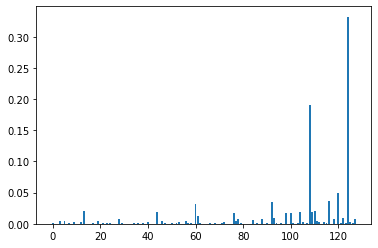

In [55]:
num = 7
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 4), 
             Edge(4, 0), Edge(0, 2), Edge(0, 3), Edge(0, 4), 
             Edge(1, 3), Edge(1, 4), Edge(2, 4), Edge(5, 0), Edge(5, 1),
            Edge(6, 3), Edge(6, 4)]
anti_graph = g_bar(set_edges)

# Defines the cost function

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6], params[8], params[10]]
    alpha = [params[1], params[3], params[5], params[7], params[9], params[11]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 12)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100, 'tol':1e-14})
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]
x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)
plt.bar(x, y)
plt.show()

<p>
                        As you can see, the tallest spike corresponds to $|124\rangle \ = \ |1111100\rangle$, which is exactly the answer we expect (the way we labelled the qubits make qubits $1$, $2$, $3$, $4$, and $5$ the middle pentagon).
                        It is possible to perform MaxClique for more complicated graphs, with increased circuit depth, but for now, we are going to leave those simulations to the reader and move on to the next QAOA application.

If you believe this was a fluke, we can also check our cost function, for the specific graph that we are interested, to ensure that the loqest energy does in fact correspond to the correct answer. All we have to do is pass in every binary representation of the integers from $0$ to $128$, and plot the cost:

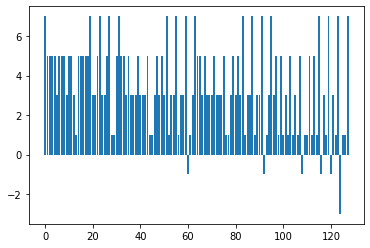

In [57]:
# Creates the cost data and plots it

def modified_cost_function(av):

    total_cost = 0
    for j in range(0, len(av)):
        total_cost += 1-2*av[j]
    for j in anti_graph.edges_set:
        total_cost += 0.5* ((-2*av[j.start_node] + 1)*(-2*av[j.end_node] + 1) - (-2*av[j.start_node] + 1) - (-2*av[j.end_node] + 1) + 1)

    return total_cost

res = [modified_cost_function([int(i) for i in list(str(bin(j))[2:].zfill(7))]) for j in range(0, 128)]
x = range(0, 128)

plt.bar(x, res)
plt.show()

And so, we can see the lowest spike is at $|124\rangle$, which is exactly what we expect!

**Solving the Travelling Salesman Problem with QAOA**

The travelling salesman problem is defined as follows : given a graph $G \ = \ (V, \ E)$, along with a metric $D_{E}(e)$ that assigns <b>distances</b> to each $e \ \in \ E$, 
                  what is the <b>path</b>, $P$, that includes all $v \ \in \ V$, such that:
                  <br><br>
                  $$C \ = \ \displaystyle\sum \ D_{E}(p) \ \ \ \forall p \ \in \ P$$
                  <br><br>
is minimized? A path is defined as some ordered list of edges, such that each edge is only included once in the list. This problem is the most daunting one that we will tackle with QAOA
                  in this Notebook. In order to solve this, we first need to come up with a good encoding scheme for the problem. The optimally chosen path, along with the list $V$ is going to be a subgraph
                  of $G$, with each vertex connected to $2$ other vertices, to form a ring-shaped structure. We are going to use this constraint during our construction of the cost function, but firstly, let us
                  define our encoding scheme to be bitstrings representing an <b>adjacency matrix</b> corresponding to our subgraph. For a graph $G$, with $n \ = \ |V(G)|$, the adjacency matrix, $A$, will be an
                  $n \ \times \ n$ matrix, such that some matrix element $A_{ij}$ is set to $1$ if there exists an edge between vertex $i$ and vertex $j$, and $0$ is there exists no such edge. For example, for the
                  graph in the previous section, the adjacency matrix is defined as:
                  <br><br>
                  $$A \ = \ \begin{pmatrix} 0 & 1 & 1 & 1 & 1 & 1 & 0 \\ 1 & 0 & 1 & 1 & 1 & 0 & 1 \\ 1 & 1 & 0 & 1 & 1 & 0 & 1 \\ 1 & 1 & 1 & 0 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 & 0 & 0 & 0
                   \\ 1 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 1 & 0 & 0 & 0 \end{pmatrix}$$
                  <br><br>
                    So when we define our path, it would make sense to also use an adjacency matrix, where the number of $1$s in a given row is equal to $2$. Now, we must consider the cost function itself. 
                    We wish to minimize the distance travelled
                    along the given path, thus we should just used the originally defined $C$ as our cost function. Each value associated with $D_E$ can be stored in some look-up table that we reference
                    when constructing our circuit. Thus, we define this part of our cost Hamiltonian as:
                    <br><br>
                    $$\hat{H} \ = \ \displaystyle\sum_{i, \ j} \ \frac{D_{ij}}{2} (1 \ - \ Z_{ij})$$
                    <br><br>
                    Where $D_{ij}$ is the distance of the edge between vertex $i$ and vertex $j$, and $Z_{ij}$ is the $Z$ gate on the qubit corresponding to the $i$-th row and $j$-th column of
                    the adjacency matrix. However, this cost function says <b>nothing</b> about the hard constraint, which is that each row of the adjacency matrix must have only two entries equal
                    to $1$. We will thus borrow a technique used in this paper: <a href="https://arxiv.org/pdf/1810.13411.pdf">"A quantum alternating operator ansatz with hard and soft constraints for 
                     lattice protein folding"</a>. Essentially, we want to encode the hard contraints of our problem in the mixer unitary, such that only the state-space of feasible solutions is explored.
                     In this case, it will be the states where the Hamming weight (sum of binary digits) of each row of the adjacency matrix is equal to $2$. In order to actually do this, we will initialize
                     our qubit register in an even superposition of qubit state with Hamming weight two (I'll talk more about this soon), and we define our mixer to be the <b>generalized SWAP gate</b>, used
                     in the referenced paper. This gate preserves Hamming weight, and is defined as:
                     <br><br>
                     $$SWAP_{i, \ j} \ = \ \frac{1}{2} (X_i X_j \ + \ Y_i Y_j)$$
                     <br><br>
                     So we define our mixer Hamiltonian as:
                     <br><br>
                     $$\hat{H}_M \ = \ \displaystyle\sum_{i, \ j} \ SWAP_{i, \ j} \ = \ \displaystyle\sum_{i, \ j} \ \frac{1}{2} (X_i X_j \ + \ Y_i Y_j)$$
                     <br><br>
                     Where we apply the terms between adjacent qubits. Now, going back to our initial desire to initialize our qubits in an even superposition of all bitstrings of Hamming weight
                     $2$, I am not smart enough to think of any rhyme or reason to the method that I have found to initialize these bitstrings, but essentially it just comes down to intuitively thinking
                     of the $\sqrt{SWAP}$ gate as something that has a $50\%$ chance of swapping qubits (while adding some local phases in the process), and trying to "balance" out the probabilities of all bitstrings of a given Hamming weight, then
                     correcting for the local phases with exponential $Z$ gates. The initialization circuits that we will use for TSP aren't exact (the probabilities of measuring the feasable bitstrings
                     are different), however, with this initialization we restrict ourselves to the subspace of feasable bitstrings. The subsequent layers of unitaries will hopefully correct for the 
                     non-uniform initialized probabilities, as we pass the initial state through
                     the QAOA circuit. There is definitely an initialization circuit such that the initial probabilities for each of feasable bitstrings are equal, so if you are reading this and bothered by the "slopiness" of this step, by all means
                     try to find the "more-correct" circuit. For now, we are going to attempt to do TSP with $3$ nodes, thus the initialization circuit that we use for each "row" of the adjacnecy matrix
                      will look something like:
                  </p>
                  <br><br>
                  <center>
                      <img src="assets/new_circuit.png" style="width:40vw">
                  </center>
                  <br><br>
                  <p>
                    For this initialization circuit, we correct for the different phases with the single quibts applied after the $\sqrt{SWAP}$ gates, however, the initial probability distribution is not uniform. 
                    <br><br>
                    In order to proceed, there is also one other hard constraint that we must consider: the fact that our bitstrings have to represent an actual adjacency matrix. Allow me to elaborate, consider the following matrix:
                    <br><br>
                    $$A \ = \ \begin{pmatrix} 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 0 & 0 & 0 & 0 & 1 & 1
                   \\ 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 0 & 0 & 0 & 0 & 1 & 1 \end{pmatrix}$$
                    <br><br>
                    This is definitely not an adjacency matrix. For instance, the top right entry of the matrix says that vertex $1$ is connected to vertex $7$, however, there is not a $1$ in the bottom left corner,
                    which signifies the same information and should be present. Thus, the idea behind our new penalty, which essentially checks if the outputted bitstring is a valid adjacency matrix is that we
                    apply $ZZ$ operations between qubits that represent reflection of one-another across the main diagonal of the adjacency matrix. In other words:
                    <br><br>
                    $$\hat{H}' \ = \ - \displaystyle\sum_{a, \ b} Z_a Z_b \ \ \ \ \ a \ = \ A_{ij} \ \ \ b \ = \ A_{ji}$$
                    <br><br>
                    And we thus arrive at our final cost Hamiltonian:
                    <br><br>
                    $$\hat{H}_C \ = \ \hat{H} \ + \ \hat{H}' \ = \ \displaystyle\sum_{i, \ j} \ \frac{D_{ij}}{2} (1 \ - \ Z_{ij}) \ - \ \omega \displaystyle\sum_{a, \ b} Z_a Z_b$$
                    <br><br>
                    Summing over all elements $A_{ij}$, except for those on the main diagonal of the adjacency matrix.
                    We can drop away the overall phase that is being added to each qubit (even though the phase is different, they all sum together to give the same effect
                    on each of the basis states). Thus, we are simply left with:
                    <br><br>
                    $$\hat{H}_{C} \ = \ - \frac{1}{2} \displaystyle\sum_{i, \ j} \ D_{ij} Z_{ij} \ - \ \omega \displaystyle\sum_{a, \ b} Z_a Z_b$$
                    <br><br>
                    Let's choose $\omega$ to be relatively large. Like before, we want to ensure that the hard-constraints are always satisfied. Thus, let's choose $\omega \ = \ 5$, and define our
                    cost unitary:
                    <br><br>
                    $$\hat{U}_C \ = \ e^{i\gamma \big(\frac{1}{2} \sum_{i, \ j} \ D_{ij} Z_{ij} \ + \ 5 \sum_{a, \ b} Z_a Z_b \big)} \ = \ e^{i \gamma \frac{1}{2} \sum_{i, \ j} \ D_{ij} Z_{ij}} 
                    e^{5 i \gamma \sum_{a, \ b} Z_a Z_b} \ = \ \displaystyle\prod_{i, \ j} e^{i \frac{\gamma}{2} D_{ij} Z_{ij}} \ \displaystyle\prod_{a, \ b} e^{5 i \gamma Z_{a} Z_{b}}$$
                    <br><br>
                    We can also define our new mixer unitary:
                    <br><br>
                    $$\hat{U}_M \ = \ e^{-i \frac{\alpha}{2} \sum_{i, \ j} (X_i X_j \ + \ Y_i Y_j)} \ = \ \displaystyle\prod_{i, \ j} e^{-i \frac{\alpha}{2} X_i X_j} e^{-i \frac{\alpha}{2} Y_i Y_j}$$
                    <br><br>
                    With all of this, we can now begin creating our simulations of QAOA TSP. For now, we are going to investigate a practically trivial problem, with only $3$ vertices. This will require
                    $9$ qubits (which is a lot, and really puts in persepctive the quadratic scaling of qubits that I'm using in this implementation). Anyways, continuing on, we can first write up
                    some code that gives us the initialization circuit:
                  </p>

In [109]:
# Defines the initialization circuit

def initialization(qubits):

    for i in range(0, int(math.sqrt(num))):

        yield cirq.X.on(cirq.GridQubit(0, i*int(math.sqrt(num))))
        yield cirq.X.on(cirq.GridQubit(0, i*int(math.sqrt(num))+1))
        yield cirq.SwapPowGate(exponent=0.5).on(qubits[i*int(math.sqrt(num))], qubits[i*int(math.sqrt(num))+2])
        yield cirq.SwapPowGate(exponent=0.5).on(qubits[i*int(math.sqrt(num))+1], qubits[i*int(math.sqrt(num))+2])

        yield cirq.X.on(cirq.GridQubit(0, i*int(math.sqrt(num))+2))
        yield cirq.S.on(cirq.GridQubit(0, i*int(math.sqrt(num))+2))
        yield cirq.Z.on(cirq.GridQubit(0, i*int(math.sqrt(num))+2))
        yield cirq.X.on(cirq.GridQubit(0, i*int(math.sqrt(num))+2))

        yield cirq.X.on(cirq.GridQubit(0, i*int(math.sqrt(num))))
        yield cirq.T.on(cirq.GridQubit(0, i*int(math.sqrt(num))))
        yield cirq.X.on(cirq.GridQubit(0, i*int(math.sqrt(num))))

<p>
                  We can then define the new cost unitary subroutine. In order to do this, we use "distance" and "coupling" lists, which we define for a specific graph later:
                  </p>

In [110]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):

    # Penalizes the distances

    for i in range (0, len(qubits)):
        yield cirq.ZPowGate(exponent=gamma*(distances[i])/(2*math.pi)).on(qubits[i])
    
    # Penalizes the hard-constraint

    for i in coupling:
        yield cirq.ZZPowGate(exponent=5*gamma/math.pi).on(qubits[i[0]], qubits[i[1]])

<p>We also define our new mixer unitary:</p>

In [111]:
# Defines the mixer unitary

def mixer_unitary(qubits, alpha):

    for i in range(0, int(math.sqrt(num))):

        yield cirq.XXPowGate(exponent=-0.5*alpha/math.pi).on(qubits[int(i*math.sqrt(num))], qubits[int(i*math.sqrt(num)+1)])
        yield cirq.YYPowGate(exponent=-0.5*alpha/math.pi).on(qubits[int(i*math.sqrt(num))], qubits[int(i*math.sqrt(num)+1)])
        yield cirq.XXPowGate(exponent=-0.5*alpha/math.pi).on(qubits[int(i*math.sqrt(num)+1)], qubits[int(i*math.sqrt(num)+2)])
        yield cirq.YYPowGate(exponent=-0.5*alpha/math.pi).on(qubits[int(i*math.sqrt(num)+1)], qubits[int(i*math.sqrt(num)+2)])
        yield cirq.XXPowGate(exponent=-0.5*alpha/math.pi).on(qubits[int(i*math.sqrt(num))], qubits[int(i*math.sqrt(num)+2)])
        yield cirq.YYPowGate(exponent=-0.5*alpha/math.pi).on(qubits[int(i*math.sqrt(num))], qubits[int(i*math.sqrt(num)+2)])

<p>And finally, we define our new cost function:</p>

In [114]:
# Defines the cost function

iterations = 0

def cost_function(params):
    
    global iterations

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in range(0, len(av[i])):
            total_cost += distances[j]*av[i][j]
        for j in coupling:
            total_cost += -5*(1 - 2*av[i][j[0]])*(1 - 2*av[i][j[1]]) 
    total_cost = float(total_cost)/rep

    if (iterations % 10 == 0):
        print("Cost at Step "+str(iterations)+": "+str(total_cost))
    
    iterations = iterations + 1

    return total_cost

<p>
                  And without further delay, we can test out our TSP algorithm on a simple graph. We'll first investigate the trivial case of a $3$-node graph.
                  <br><br>
                  We'll consider the following weighted graph:
                  </p>
                  <br><br>
                  <center>
                      <img src="assets/weight.png" style="width:400px;">
                  </center>
                  <br><br>
                  <p>
                      This problem is <b>beyond</b> trivial, there is literally only one choice for a path through this graph, but nevertheless, we will perform TSP on it. First, let us
                      define the distance matrix for this graph:
                      <br><br>
                    $$D \ = \ \begin{pmatrix} 15 & 5 & 3 \\ 5 & 15 & 4 \\ 3 & 4 & 15 \end{pmatrix}$$
                      <br><br>
                      We chose the digagnal elemnts to be large, as we want to "repel" our simulation away from placing $1$s on the diagonal of adjacency matrix (as we previously explained).
                      The "coupling" list included within our code just includes a list of all pairs that are reflections of each other across the main diagonal of a $3 \ \times \ 3$ matrix. Now, just as a test
                      we can take graph a plot of our cost function for all feasable bitstrings (bitstrings that don't represent possible adjacency matrices aren't included in this plot):
                  </p>
                  <br><br>
                  <center>
                  <img src="assets/cost_f.png" style="width:400px;">
                </center>
                  <br><br>

<p>
                      As you can see, our cost function takes on its minimum value at $x \ = \ 238$, which we will soon see is in fact the correct solution to the TSP problem we
                      have outlined. Finally, we can
                      encode this information and the graph easily into our pre-existing "graph code", and run the simulation:
                  </p>

Cost at Step 180: 41.261
Cost at Step 190: 46.749
Cost at Step 200: 33.882
Cost at Step 210: 31.368
Cost at Step 220: 32.038
Cost at Step 230: 30.896
Cost at Step 240: 31.079
Cost at Step 250: 30.588
Cost at Step 260: 32.632
Cost at Step 270: 30.423
Cost at Step 280: 30.447
Cost at Step 290: 30.493
Cost at Step 300: 31.76
Cost at Step 310: 31.12
Cost at Step 320: 31.023
Cost at Step 330: 31.715
Cost at Step 340: 31.366
     fun: 32.153
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 178
  status: 1
 success: True
       x: array([ 3.8340313 ,  0.41434788, -2.45815435,  2.53572242,  1.23599522,
        0.68098454,  2.16762994,  0.67521316])
[238, 347, 414, 427, 237, 366, 365, 430, 221, 235, 222, 438, 413, 350, 371, 243, 246, 437, 411, 363, 219, 349, 245, 429, 374]
[0.315, 0.033, 0.02, 0.03, 0.048, 0.038, 0.03, 0.039, 0.054, 0.088, 0.013, 0.036, 0.03, 0.04, 0.012, 0.011, 0.047, 0.002, 0.024, 0.019, 0.016, 0.021, 0.015, 0.018, 0.001]


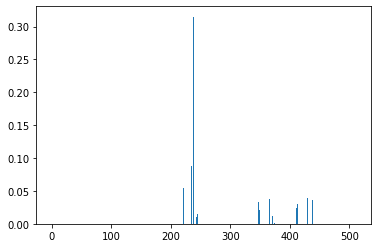

In [116]:
num = 9
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

distances = [15, 5, 3, 5, 15, 4, 3, 4, 15]
coupling = [[1, 3], [2, 6], [5, 7]]

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))

    #print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':1000}, tol=1e-10)
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()

<p>
                  As can be seen, the tallest spike (the highest probability) lies at the state $|238\rangle \ = \ |011101110\rangle$. We can translate this into a matrix:
                  <br><br>
                  $$A \ = \ \begin{pmatrix} 0 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 0 \end{pmatrix}$$
                  <br><br>
                  Which is exactly the path that through the matrix, thus $|238\rangle$ is the correct solution. This simulation actually yields incorrect results for some trials. This may be explained
                  by the fact that the initial state is far from optimal, the search space of the mixers is already constrained to an extent such that altering amplitudes requires finer adjustments to converge, or
                  that TSP is an inherently volatile problem that requires increased circuit depth and/or better tuning of parameters in the cost function. All of these possible faults could be remedied, and
                  I believe that the algorithm would perform even better if we made these corrections (in this expository Notebook, we will not spend time doing that, but the eager reader of this Notebook may be interested
                  in trying to increase the quality of the simulations).
                  <br><br>
                  To conclude all of our TSP simulations, let's attempt to solve a problem that is slightly less trivial than the one that we just did: a $4$ vertex graph. Specifically, we will investigate:
                  </p>
                  <br><br>
                  <center>
                      <img src="assets/tsp2.png" style="width:400px;">
                  </center>
                  <br><br>
                 <p>We will use pretty much the exact same code as before, with the same restrictions on the search space, and a new distance matrix that encodes all of the edges of this particular graph.
                     The only thing that changes is the initialization circuit, which now needs to accomodate $4$ qubits:
                 </p>                 
                 <br><br>
                 <center>
                    <img src="assets/new_init.png" style="width:40vw">
                 </center>
                 <br><br>
                     <p>
                   Again, this circuit does not yield an even distribution over all feasable states, and is probably not optimized, but it serves its function: restricting us to the subspace of realizable solutions.
                   We won't display the cost function for this instance of TSP, because frankly, the range is too large to render and actually zoom in on the minima (I tried). Instead, we will jump directly
                   to running QAOA TSP. We get a distribution that looks something like this (we ommit the code as it is essentially identical to that of the prvious simualtion, with the input coupling and distance matrices altered):
                 </p>
                 <br><br>
                 <center>
                     <img src="assets/tgraph4.png" style="width:400px;">
                 </center>
                 <br><br>
                 <p>
                     The tallest spikes (marked by the orange dots) in our simulation correspond to the states $|23130\rangle \ = \ |0101101001011010\rangle$ and $|27030\rangle \ = \ | 0110100110010110 \rangle$.
                     The bitstrings map to the following adjacnecy matrices:
                     <br><br>
                    $$A_{23130} \ = \ \begin{pmatrix} 0 & 1 & 0 & 1 \\ 1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & 1 & 0 \end{pmatrix} \ \ \ \ \ \ \ \ \ A_{27030} \ = \ \begin{pmatrix} 0 & 1 & 1 & 0 \\ 1 & 0 & 0 & 1 \\ 1 & 0 & 0 & 1 \\ 0 & 1 & 1 & 0 \end{pmatrix}$$
                     <br><br>
                     The first adjacency matrix represents the outer ring around the graph (as you can check), which has cost $5 \ + \ 4 \ + \ 2 \ + \ 7 \ = \ 18$. The second adjacency matrix represents
                     the "more horizontal" hourgalss cycle within the graph, which has cost $5 \ + \ 8 \ + \ 2 \ + \ 3 \ = \ 18$. We can quickly check the cost of the one remaining cycle within our graph, which
                     is the "more horizontal" hourglass structure (its cost is $7 \ + \ 3 \ + \ 8 \ + \ 4 \ = \ 22$), verifying that our simulation has converged on the optimal solutions! It is important to note
                     that like the first simulation, this simulation more volatile than one would hope (it doesn't always converge, and requires the constrained parameter search space), but like I mentioned previously,
                     I believe this can be fixed by making the previously outlined modifcations to the algorithm.

**Conclusion and Further Applications**

I want to end off this Notebook by re-iterating the power of graph theory. Graphs are very general and very useful mathematical structures. Essential any system that involves multiple
                  "agents", each of which are interacting with one another in different ways, a graph provides a really good (yet, very simplified) mathematical picture of what exactly is going on. The
                  graphs that we investigated in this post didn't necessarily represent any system that we see in the real world, however, they could. 

For instance, ProteinQure and Xanadu, two Toronto-based
                  startups released a two papers a little while back, one of which is using QAOA to solve the protein folding problem (by modelling proteins as graphs), and another which attempts to predict
                  molecular docking using an approach to solving graph problems called Gaussian Boson Sampling. This is different from QAOA, but at the root, they were essentially trying to find the maximum
                  clique of a molecular, to precict binding sites, which they theoretically could have just used QAOA MaxClique to find!
                  </p>
                  <p class="tsp">
                  In addition to this cool work, I was recently scrolling through Twitter (probably procrastinating, when I should have been working on this Notebook), and I came across a guy 
                  named <a href="https://twitter.com/kvogt">Kyle Vogt</a>, who just recently finished running <b>7 marathons on 7 continents in 81 hours</b>. I enjoy running, but such an expedition
                  would surely result in my painful and hasty demise before I even finished the first half of the first marathon, so I was naturally very impressed by this superhuman endeavour. 
                  I became even more impressed/intrigued when I came across the <a href="https://github.com/kvogt/around_the_world">code that he used to plan his trip</a>. To choose his path around the world, Vogt used a variant of the Travelling Salesman Problem. Through
                  encoding a bunch of constraints like location of airports, physical connection to the mainland, and war-torn countries where there was a non-zero probability of his plane being shot down, he performed
                  TSP between a bunch of cities/Antarctic research bases, and found the optimal route. Theoretically, if Vogt had enough qubits (which he wouldn't, at least with current quantum computational devices),
                  Vogt could have observed a computational speedup when planning his trip by using TSP! So as you can so, there are (theoretical, painfully theoretical) applications everywhere, 
                  ranging from modelling proteins, to planning an ultra-ultra-ultra marathon. 

**Acknowledgements and Further Reading**

Thank you to Maggie Li for providing detailed feedback and suggestions on the original draft of the blog post that was adapted to make this Notebook.

There are a few resources I reccomend that may interest the especially motivated reader:

- Original QAOA Paper: https://arxiv.org/abs/1411.4028
- Qiskit Textbook Entry on QAOA: https://qiskit.org/textbook/ch-applications/qaoa.html
- Amazing Lecture Notes on QAOA: https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf
- Comprehensive Paper on Uses/Theory Behind QAOA: https://arxiv.org/pdf/1709.03489.pdf